# Fourth batch all prop

### get the properties for all trees

In [1]:
from astropy.io import fits
from astropy import units as u
import numpy as np
import pickle
from cube_fil_finder.structs import util as struct_util
from cube_fil_finder.galfa import galfa_const
from cube_fil_finder.galfa import galfa_util
from cube_fil_finder.util import cube_moments
from cube_fil_finder.util import moments
from cube_fil_finder.util import widths
from cube_fil_finder.util import cube_util

from matplotlib import pyplot as plt
from fil_finder import FilFinder2D

%matplotlib inline

In [3]:
# load in all trees
pickle_path_trees_1_8 = '../../pickled_dicts/fourth_batch/all_trees_1_8.p'
trees_1_8 = pickle.load(open(pickle_path_trees_1_8, 'rb'))

In [213]:
trees_1_8['3257_955_0']

<cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x11d7ef7e8>

In [214]:
print(len(trees_1_8))

1137


In [215]:
# for future use, keys sorted in descending order by masked area
keys_1_8 = struct_util.sorted_struct_dict_keys_by_area(trees_1_8.keys(), 'tree')

For each tree:
width, aspect ratio (roundedness approx), size (masked area), coord (ra&dec, l&b), column density (peak, avg & median), moment_0_1_2 (peak, avg & median), velocity span, average velocity

# Example filament & testing on using raw cubes vs the usharp cubes

In [216]:
# example header
hdr = fits.getheader('/Volumes/LarryExternal1/Research_2017/GALFA_slices_backup/umask_gaussian_30/GALFA_HI_W_S0955_V-050.4kms_umask.fits')

In [229]:
ex_tree = trees_1_8['3257_955_0']

In [230]:
# for astropy.unit conversions
hdr['BUNIT'] = 'k'

In [231]:
# get a list of cut (to tree corners & tree velocities), raw galfa slices
tree_data_cube_raw = galfa_util.get_galfa_data_cube_from_tree(ex_tree, cube_type='raw')
# convert the list of slices into a 2d image of the moment0 map
moment_0_map_raw = np.nan_to_num(cube_moments.moment_0_from_cube(tree_data_cube_raw))
# unsharpmask (gaussian30) mask the moment0 map from raw slices
moment_0_map_raw = cube_util.umask(moment_0_map_raw, radius=30, filter_opt='gaussian')
# get a list of cut (to tree corners & tree velocities), umask galfa slices
tree_data_cube_umask = galfa_util.get_galfa_data_cube_from_tree(ex_tree, cube_type='umask30')
# convert the list of slices into a 2d image of the moment0 map
moment_0_map_umask = np.nan_to_num(cube_moments.moment_0_from_cube(tree_data_cube_umask))

(193, 149)


In [232]:
# filfinder obj for raw slices --> moment 0 --> unsharp masking
fils_raw = FilFinder2D(moment_0_map_raw, header=hdr, distance=100. * u.pc, beamwidth=10. * u.arcmin,
                       mask=ex_tree.root_node.mask)
fils_raw.preprocess_image(flatten_percent=95)
# filfinder obj for umask slices --> moment 0
fils_umask = FilFinder2D(moment_0_map_umask, header=hdr, distance=100. * u.pc, beamwidth=10. * u.arcmin,
                       mask=ex_tree.root_node.mask)
fils_umask.preprocess_image(flatten_percent=95)

In [233]:
# use existing mask from our trees
fils_raw.create_mask(use_existing_mask=True, verbose=True)
fils_umask.create_mask(use_existing_mask=True, verbose=True)

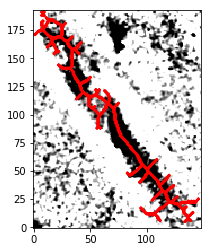

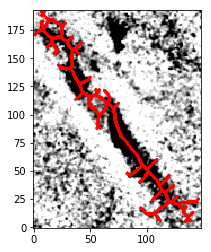

In [234]:
# mask skeleton from mask
fils_raw.medskel(verbose=True)
fils_umask.medskel(verbose=True)

In [235]:
fils_raw.analyze_skeletons(skel_thresh=.1 * 8 * u.pc)
fils_umask.analyze_skeletons(skel_thresh=.1 * 8 * u.pc)

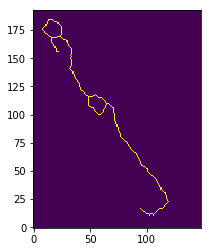

In [236]:
plt.imshow(fils_raw.skeleton, origin='lower')

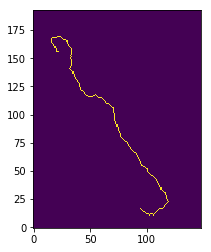

In [237]:
plt.imshow(fils_raw.skeleton_longpath, origin='lower')

In [238]:
fils_raw.exec_rht()
fils_umask.exec_rht()

Filament: 1 / 1


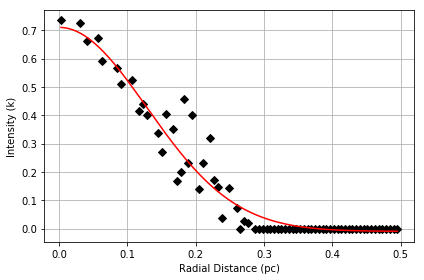

In [239]:
fils_raw.find_widths(try_nonparam=False, auto_cut=False,
                     max_dist=0.5 * u.pc, verbose=True,
                     use_longest_path=False, add_width_to_length=False,
                     deconvolve_width=False, xunit=u.pc)

Filament: 1 / 1


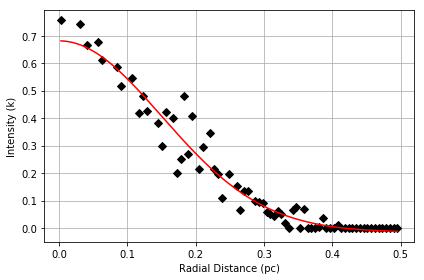

In [240]:
fils_umask.find_widths(try_nonparam=False, auto_cut=False, use_longest_path=False,max_dist=0.5 * u.pc,
                       verbose=True, add_width_to_length=False, xunit=u.pc, deconvolve_width=False)

In [241]:
print(fils_raw.lengths(unit=u.pc))
print(fils_umask.lengths(unit=u.pc))

[ 7.25952223] pc
[ 7.25952223] pc


In [242]:
print(fils_raw.widths(unit=u.pc))
print(fils_umask.widths(unit=u.pc))

(<Quantity [ 0.30298717] pc>, <Quantity [ 0.00871376] pc>)
(<Quantity [ 0.35317503] pc>, <Quantity [ 0.00888843] pc>)


## ONLY RE RUN THIS TO RE CALCULATE PROPERTIES OTHERWISE LOAD FROM PICKELD FILE

In [126]:
bad_list = ['704_1035_1','395_1016_10','4125_1023_1','880_1030_4','616_1025_11','1571_1005_0','947_1033_1','405_1033_0','666_1021_5','1120_961_0','1169_1040_1','827_1041_0','1736_1024_0','794_1027_2','1274_1037_1','453_1008_5','1806_1021_0']

In [127]:
bad_list2 = ['5177_1014_0',
'3257_955_0',
'1139_1024_3',
'2554_1031_0',
'386_1025_2',
'3728_1012_0',
'9657_1026_0',
'2101_1023_0',
'3385_1036_0',
'593_1021_5',
'666_1021_5',
'4061_1016_0',
'3612_1005_0',
'2442_1037_1',
'3482_982_0',
'419_1021_15',
'2816_1034_0',
'2835_1013_0',
'7659_1005_0',
'880_1025_4',
'518_1012_4',
'4081_1018_0',
'4557_1016_0',
'757_1041_5']

In [77]:
# calculate all the properties for these filaments
trees_data_1_8 = {}
for i, k in enumerate(keys_1_8):
    tree = trees_1_8[k]
    print('on tree {0}, {1} out of {2}'.format(k, i, len(trees_1_8)))
    
    corners = tree.root_node.corners_original
    # skip this process for filaments that are too close to the edges
    if (
    corners[1][0] > galfa_const.GALFA_Y_STEPS - 10 or \
    corners[1][1] > galfa_const.GALFA_X_STEPS - 10 or \
    corners[0][0] < 10 or \
    corners[0][1] < 10):
        trees_data_1_8[k] = {}
        continue 

    # 2d binary numpy mask
    tree_mask = tree.root_node.mask
    # number of pixels masked
    tree_size = tree.root_node.masked_area_size
    # velocity span in km/s from number of channels
    tree_v_span = tree.length * galfa_const.GALFA_W_SLICE_SEPARATION
    tree_starting_v_index = tree.root_v_slice

    # "average velocity" use mean/med/max of moment 1 map instead
    tree_avg_v = galfa_util.galfa_v_lookup_from_index(tree_starting_v_index + tree_v_span / 2.)
    
    # centroid and roundness measurement of the mask
    x_bar, y_bar, theta_1, theta_2, tree_roundness = moments.get_tree_mask_orientation_info(tree)
    # conversion of the centroid index into ra&dec and l&b
    tree_ra, tree_dec = galfa_util.galfa_index_to_radecs(x_bar, y_bar)
    tree_l, tree_b = galfa_util.galfa_index_to_lb(x_bar, y_bar)
    
    # list of cut umask slices
    tree_data_cube = galfa_util.get_galfa_data_cube_from_tree(tree)
    # list of cut raw slices
    tree_data_cube_raw = galfa_util.get_galfa_data_cube_from_tree(tree, cube_type='raw')

    # moment 0 from the umask slices
    full_moment_0_map = np.nan_to_num(cube_moments.moment_0_from_cube(tree_data_cube))
    # moment 0 from the raw slices
    full_moment_0_map_raw = np.nan_to_num(cube_moments.moment_0_from_cube(tree_data_cube_raw))
    # unsharp masking the moment 0 from the raw slices
    full_moment_0_map_umask = cube_util.umask(full_moment_0_map_raw, radius=30, filter_opt='gaussian')

    # moment 0, 1, 2, column maps with pixels not in the mask NaN'd out
    moment_0_map = cube_moments.moment_0_from_cube(tree_data_cube, mask=tree_mask)
    moment_0_map_raw = full_moment_0_map_umask.copy()
    moment_0_map_raw[np.where(tree_mask == 0)] = np.nan
    moment_1_map = cube_moments.moment_1_from_cube(tree_data_cube, tree_starting_v_index, tree.length, mask=tree_mask)
    moment_2_map = cube_moments.moment_2_from_cube(tree_data_cube, tree_starting_v_index, tree.length, mask=tree_mask)
    column_density_map = cube_moments.column_density_from_moment_0_map(moment_0_map)
    column_density_map_raw = cube_moments.column_density_from_moment_0_map(moment_0_map_raw)

    # width fits, errors, and chisq from both the (umask-->moment0) and the (raw-->moment0-->umask) moment0s
    width_fit, width_fit_err, chisq = widths.get_width_fit_filfind(full_moment_0_map, tree, hdr)
    width_fit_raw, width_fit_err_raw, chisq_raw = widths.get_width_fit_filfind(full_moment_0_map_umask, tree, hdr)

    tree_data = {}
    tree_data['key_num'] = i
    tree_data['roundness'] = tree_roundness
    tree_data['size'] = tree_size
    tree_data['ra_dec'] = [tree_ra, tree_dec]
    tree_data['l_b'] = [tree_l, tree_b]
    tree_data['velocity_span'] = tree_v_span
    tree_data['starting_velocity'] = galfa_util.galfa_v_lookup_from_index(tree.root_v_slice)
    tree_data['average_velocity'] = tree_avg_v
    tree_data['moment_0_peak'] = np.nanmax(moment_0_map)
    tree_data['moment_0_peak_raw']= np.nanmax(moment_0_map_raw)
    tree_data['moment_0_mean'] = np.nanmean(moment_0_map)
    tree_data['moment_0_mean_raw']= np.nanmean(moment_0_map_raw)
    tree_data['moment_0_median'] = np.nanmedian(moment_0_map)
    tree_data['moment_0_median_raw']= np.nanmedian(moment_0_map_raw)
    tree_data['moment_1_mean'] = np.nanmean(moment_1_map)
    tree_data['moment_1_median'] = np.nanmedian(moment_1_map)
    tree_data['moment_2_peak'] = np.nanmax(moment_2_map)
    tree_data['moment_2_mean'] = np.nanmean(moment_2_map)
    tree_data['moment_2_median'] = np.nanmedian(moment_2_map)
    tree_data['column_density_peak'] = np.nanmax(column_density_map)
    tree_data['column_density_peak_raw'] = np.nanmax(column_density_map_raw)
    tree_data['column_density_mean'] = np.nanmean(column_density_map)
    tree_data['column_density_mean_raw'] = np.nanmean(column_density_map_raw)
    tree_data['column_density_median'] = np.nanmedian(column_density_map)
    tree_data['column_density_median_raw'] = np.nanmedian(column_density_map_raw)
    tree_data['width_fit'] = width_fit
    tree_data['width_fit_raw'] = width_fit_raw
    tree_data['width_err'] = width_fit_err
    tree_data['width_err_raw'] = width_fit_err_raw
    tree_data['width_chisq'] = chisq
    tree_data['width_chisq_raw'] = chisq_raw
    
    trees_data_1_8[k] = tree_data

on tree 19662_1016_0, 0 out of 1137
(407, 903)
on tree 17234_1020_0, 1 out of 1137
on tree 14521_1033_0, 2 out of 1137
(182, 695)
on tree 12348_1035_0, 3 out of 1137
(98, 658)
on tree 11497_1026_0, 4 out of 1137
(101, 620)
on tree 11260_1027_0, 5 out of 1137
(96, 601)
on tree 11019_1026_0, 6 out of 1137
(77, 558)
on tree 10771_990_0, 7 out of 1137
(257, 610)
on tree 10016_1010_0, 8 out of 1137
on tree 9657_1026_0, 9 out of 1137
(263, 387)
on tree 9614_988_0, 10 out of 1137
(231, 585)
on tree 9408_1064_0, 11 out of 1137
(471, 120)
on tree 9320_1018_0, 12 out of 1137
(327, 352)
on tree 8985_1039_0, 13 out of 1137
(148, 569)
on tree 8944_1021_0, 14 out of 1137
(314, 448)
on tree 8417_1032_0, 15 out of 1137
(97, 484)
on tree 8316_967_0, 16 out of 1137
(381, 235)
on tree 8150_1024_0, 17 out of 1137
(178, 504)
on tree 7929_1043_0, 18 out of 1137
(90, 452)
on tree 7852_1027_0, 19 out of 1137
(210, 375)
on tree 7659_1005_0, 20 out of 1137
(70, 501)
on tree 7339_1012_0, 21 out of 1137
(122, 443

on tree 3152_1031_0, 176 out of 1137
(292, 57)
on tree 3140_1020_0, 177 out of 1137
(111, 266)
on tree 3135_1033_0, 178 out of 1137
(343, 71)
on tree 3106_1016_0, 179 out of 1137
(139, 310)
on tree 3104_1034_0, 180 out of 1137
(140, 229)
on tree 3102_977_0, 181 out of 1137
(63, 227)
on tree 3100_1007_0, 182 out of 1137
(186, 304)
on tree 3100_1027_0, 183 out of 1137
(108, 238)
on tree 3090_1031_0, 184 out of 1137
(554, 464)
on tree 3089_1011_0, 185 out of 1137
(293, 200)
on tree 3087_1009_0, 186 out of 1137
(132, 224)
on tree 3084_1031_0, 187 out of 1137
(45, 304)
on tree 3068_992_0, 188 out of 1137
(123, 235)
on tree 3066_1023_0, 189 out of 1137
(173, 236)
on tree 3049_1013_1, 190 out of 1137
(254, 282)
on tree 3034_1037_0, 191 out of 1137
(189, 158)
on tree 3023_1041_0, 192 out of 1137
(143, 216)
on tree 3013_1022_0, 193 out of 1137
(178, 234)
on tree 3010_1026_1, 194 out of 1137
(194, 164)
on tree 2995_1026_0, 195 out of 1137
(94, 263)
on tree 2991_974_0, 196 out of 1137
(52, 240)
o

on tree 2014_1016_0, 351 out of 1137
(101, 287)
on tree 2014_1023_0, 352 out of 1137
(137, 190)
on tree 2013_1032_0, 353 out of 1137
(87, 228)
on tree 2010_1016_0, 354 out of 1137
(150, 292)
on tree 2008_1018_0, 355 out of 1137
(125, 175)
on tree 2006_1019_1, 356 out of 1137
(57, 432)
on tree 2003_1059_0, 357 out of 1137
(184, 82)
on tree 1995_1035_1, 358 out of 1137
(100, 208)
on tree 1991_1024_0, 359 out of 1137
(99, 190)
on tree 1984_971_0, 360 out of 1137
(186, 489)
on tree 1983_1022_0, 361 out of 1137
(143, 124)
on tree 1980_1030_0, 362 out of 1137
(348, 252)
on tree 1978_1028_0, 363 out of 1137
(26, 212)
on tree 1971_1001_0, 364 out of 1137
(73, 251)
on tree 1969_1030_0, 365 out of 1137
(28, 218)
on tree 1966_1008_0, 366 out of 1137
(107, 161)
on tree 1964_1032_0, 367 out of 1137
(40, 220)
on tree 1963_1062_0, 368 out of 1137
(118, 178)
on tree 1957_1031_0, 369 out of 1137
(134, 149)
on tree 1956_1041_1, 370 out of 1137
(74, 233)
on tree 1955_1020_0, 371 out of 1137
(187, 57)
on 

(31, 173)
on tree 1465_1020_0, 526 out of 1137
(65, 237)
on tree 1464_1015_0, 527 out of 1137
(100, 152)
on tree 1456_1006_0, 528 out of 1137
(160, 204)
on tree 1452_1022_0, 529 out of 1137
(45, 153)
on tree 1449_1031_2, 530 out of 1137
(42, 152)
on tree 1449_1024_1, 531 out of 1137
(50, 297)
on tree 1425_965_0, 532 out of 1137
(57, 184)
on tree 1416_1017_0, 533 out of 1137
(66, 201)
on tree 1415_1024_2, 534 out of 1137
(33, 150)
on tree 1411_1022_0, 535 out of 1137
(47, 161)
on tree 1405_988_0, 536 out of 1137
(99, 227)
on tree 1404_957_0, 537 out of 1137
(65, 138)
on tree 1404_1024_0, 538 out of 1137
(70, 143)
on tree 1400_1026_0, 539 out of 1137
(25, 141)
on tree 1396_1014_0, 540 out of 1137
(57, 151)
on tree 1394_989_0, 541 out of 1137
(65, 371)
on tree 1388_1027_0, 542 out of 1137
(67, 136)
on tree 1383_1060_0, 543 out of 1137
(179, 47)
on tree 1381_1023_2, 544 out of 1137
(97, 160)
on tree 1376_1041_1, 545 out of 1137
(358, 163)
on tree 1371_1034_0, 546 out of 1137
(55, 170)
on t

on tree 997_1020_1, 701 out of 1137
(122, 284)
on tree 997_1025_0, 702 out of 1137
(30, 182)
on tree 994_1050_0, 703 out of 1137
(132, 182)
on tree 993_1025_0, 704 out of 1137
(113, 106)
on tree 990_1028_0, 705 out of 1137
(32, 136)
on tree 989_1034_0, 706 out of 1137
(81, 281)
on tree 989_1044_2, 707 out of 1137
(507, 90)
on tree 989_1009_1, 708 out of 1137
(56, 108)
on tree 989_999_3, 709 out of 1137
(108, 58)
on tree 988_1009_0, 710 out of 1137
(36, 169)
on tree 986_1010_0, 711 out of 1137
(153, 223)
on tree 984_1061_0, 712 out of 1137
(106, 62)
on tree 982_1014_1, 713 out of 1137
(45, 131)
on tree 980_1038_5, 714 out of 1137
(194, 173)
on tree 976_1030_3, 715 out of 1137
(63, 111)
on tree 973_1024_0, 716 out of 1137
(24, 122)
on tree 970_1023_3, 717 out of 1137
(52, 168)
on tree 969_974_1, 718 out of 1137
(235, 132)
on tree 968_1035_4, 719 out of 1137
(129, 220)
on tree 968_1018_3, 720 out of 1137
(83, 145)
on tree 967_1022_5, 721 out of 1137
(55, 125)
on tree 967_1025_0, 722 out o

(75, 93)
on tree 695_1042_5, 881 out of 1137
(61, 73)
on tree 693_995_2, 882 out of 1137
(59, 135)
on tree 689_1008_2, 883 out of 1137
(213, 183)
on tree 689_1031_1, 884 out of 1137
(46, 227)
on tree 689_983_2, 885 out of 1137
(134, 128)
on tree 684_969_2, 886 out of 1137
(84, 188)
on tree 684_1054_7, 887 out of 1137
(116, 33)
on tree 684_1029_4, 888 out of 1137
(84, 265)
on tree 683_1039_1, 889 out of 1137
(81, 130)
on tree 683_1030_2, 890 out of 1137
(88, 144)
on tree 683_1024_2, 891 out of 1137
(66, 167)
on tree 682_1021_0, 892 out of 1137
(34, 203)
on tree 682_1027_0, 893 out of 1137
(43, 151)
on tree 681_1000_8, 894 out of 1137
(188, 85)
on tree 676_1021_3, 895 out of 1137
(61, 105)
on tree 676_1008_2, 896 out of 1137
on tree 675_971_3, 897 out of 1137
(203, 73)
on tree 673_1021_1, 898 out of 1137
(57, 224)
on tree 671_1012_6, 899 out of 1137
(50, 81)
on tree 671_1034_5, 900 out of 1137
(59, 141)
on tree 668_1041_3, 901 out of 1137
(74, 71)
on tree 666_1037_2, 902 out of 1137
(109

(129, 174)
on tree 458_1023_8, 1059 out of 1137
(111, 136)
on tree 458_1033_5, 1060 out of 1137
(33, 72)
on tree 456_1031_2, 1061 out of 1137
(222, 90)
on tree 455_1020_21, 1062 out of 1137
(78, 127)
on tree 455_1017_10, 1063 out of 1137
(95, 253)
on tree 455_1033_16, 1064 out of 1137
(164, 225)
on tree 454_1030_4, 1065 out of 1137
(327, 382)
on tree 453_1008_5, 1066 out of 1137
(21, 118)
on tree 452_1029_1, 1067 out of 1137
on tree 451_1022_5, 1068 out of 1137
(170, 257)
on tree 450_1028_12, 1069 out of 1137
(32, 166)
on tree 450_1029_3, 1070 out of 1137
(118, 24)
on tree 448_1018_16, 1071 out of 1137
(123, 240)
on tree 446_1023_13, 1072 out of 1137
(52, 297)
on tree 445_1022_5, 1073 out of 1137
(105, 384)
on tree 444_1026_10, 1074 out of 1137
(83, 356)
on tree 444_1021_6, 1075 out of 1137
(90, 260)
on tree 444_1061_11, 1076 out of 1137
(32, 97)
on tree 442_1008_3, 1077 out of 1137
(30, 135)
on tree 439_1040_9, 1078 out of 1137
(59, 200)
on tree 438_1026_3, 1079 out of 1137
(40, 192)


In [130]:
# fixing index
for i, k in enumerate(keys_1_8):
    if k in trees_data_1_8:
        trees_data_1_8[k]['key_num'] = i

### saving

In [132]:
pickle.dump(trees_data_1_8,open('../../pickled_dicts/fourth_batch/all_trees_1_8_prop.p', 'wb'))

### loading

In [133]:
trees_data_1_8 = pickle.load(open('../../pickled_dicts/fourth_batch/all_trees_1_8_prop.p', 'rb'))

In [134]:
len(trees_data_1_8)

1073

### take out obvious basket weaves

In [135]:
bad_keys = ['418_1050_6', '467_1074_13', '620_1013_3', '675_971_3', '684_1054_7', '791_1055_3',
            '810_1017_1', '850_993_2', '859_1000_1', '940_1015_3', '1083_1061_2', '1175_1061_0',
            '1383_1060_0', '3933_1027_0',
            '375_1057_25', '798_1012_3', '947_1049_0', '1039_1056_0', '1060_1008_0', '1259_1063_0',
            '2029_1055_0',
            '900_1066_1']

In [136]:
for k in bad_keys:
    trees_data_1_8.pop(k, None)

### take out edge trees

In [137]:
bad_keys2 = []
for k in trees_data_1_8:
    if trees_data_1_8[k] == {}:
        bad_keys2.append(k)

In [138]:
for k in bad_keys2:
    trees_data_1_8.pop(k, None)

In [139]:
len(trees_data_1_8)

1073

## final save

In [140]:
pickle.dump(trees_data_1_8, open('../../pickled_dicts/fourth_batch/all_trees_1_8_prop.p', 'wb'))

## Output to txt formatting

In [141]:
data_dict = pickle.load( open('../../pickled_dicts/fourth_batch/all_trees_1_8_prop.p', 'rb'))

In [142]:
tree_keys = struct_util.sorted_struct_dict_keys_by_area(data_dict.keys(), 'tree')

In [143]:
data_dict['576_970_7']

{'average_velocity': -38.27838766,
 'column_density_mean': 5.2279652846927421e+18,
 'column_density_mean_raw': 5.0252023037875927e+18,
 'column_density_median': 3.5689061987822766e+18,
 'column_density_median_raw': 3.4070665864899011e+18,
 'column_density_peak': 3.8830119803970634e+19,
 'column_density_peak_raw': 3.8830119803970626e+19,
 'key_num': 965,
 'l_b': [200.31944215477643, 73.079312490159],
 'moment_0_mean': 2.8677812861726508,
 'moment_0_mean_raw': 2.7565563926426733,
 'moment_0_median': 1.9577104765673485,
 'moment_0_median_raw': 1.8689339476082836,
 'moment_0_peak': 21.300120572666284,
 'moment_0_peak_raw': 21.30012057266628,
 'moment_1_mean': -37.795377499865751,
 'moment_1_median': -37.783985363690384,
 'moment_2_mean': 0.82175770813653892,
 'moment_2_median': 0.88330193100400178,
 'moment_2_peak': 1.4568074314507646,
 'ra_dec': [173.80832095, 29.525054350000001],
 'roundness': 0.013896847480647095,
 'size': 5574,
 'starting_velocity': -39.38257192,
 'velocity_span': 3.68

In [144]:
data_dict['1201_1022_4']

{'average_velocity': -0.73612284,
 'column_density_mean': 1.8718030427876247e+18,
 'column_density_mean_raw': 1.7759796819029527e+18,
 'column_density_median': 1.6737225984632486e+18,
 'column_density_median_raw': 1.5882882991651502e+18,
 'column_density_peak': 7.5056202017840282e+18,
 'column_density_peak_raw': 7.2800161405940593e+18,
 'key_num': 613,
 'l_b': [15.708695676057687, 68.95338124997585],
 'moment_0_mean': 1.0267707310957896,
 'moment_0_mean_raw': 0.97420717603014406,
 'moment_0_median': 0.91811442592608261,
 'moment_0_median_raw': 0.87124975269618776,
 'moment_0_peak': 4.1171805824377552,
 'moment_0_peak_raw': 3.993426297637992,
 'moment_1_mean': -0.68319365837006518,
 'moment_1_median': -0.70704565820653453,
 'moment_2_mean': 0.31499138727828574,
 'moment_2_median': 0.35944352715843286,
 'moment_2_peak': 0.36806141896818068,
 'ra_dec': [214.17506835, 19.325033950000002],
 'roundness': 0.0094271223630911418,
 'size': 2368,
 'starting_velocity': -1.10418426,
 'velocity_span

In [145]:
data_dict['1040_1005_0']

{'average_velocity': -12.51408827,
 'column_density_mean': 5.1118463815229e+18,
 'column_density_mean_raw': 4.8753568799222385e+18,
 'column_density_median': 2.8757376279516017e+18,
 'column_density_median_raw': 2.6025914902828119e+18,
 'column_density_peak': 2.9442449774086758e+19,
 'column_density_peak_raw': 2.9449879351291707e+19,
 'key_num': 681,
 'l_b': [285.85657944982466, 73.04681659814872],
 'moment_0_mean': 2.8040846854212291,
 'moment_0_mean_raw': 2.6743592319924514,
 'moment_0_median': 1.5774753856015371,
 'moment_0_median_raw': 1.4276420681748831,
 'moment_0_peak': 16.150548422428283,
 'moment_0_peak_raw': 16.154623889902197,
 'moment_1_mean': -12.746978180374677,
 'moment_1_median': -12.708950449401183,
 'moment_2_mean': 0.49019023767692416,
 'moment_2_median': 0.54143623316130207,
 'moment_2_peak': 0.73572315604511285,
 'ra_dec': [187.85834904999999, 10.84168365],
 'roundness': 0.012486019580986918,
 'size': 1292,
 'starting_velocity': -13.61827253,
 'velocity_span': 2.20

In [146]:
data_dict.keys()

['1105_1007_0',
 '392_1026_11',
 '714_1016_5',
 '5582_1023_0',
 '1291_1032_0',
 '4725_986_0',
 '2288_1035_0',
 '2332_1031_0',
 '572_1040_4',
 '668_1041_3',
 '1141_1018_2',
 '4359_981_0',
 '1095_1020_3',
 '1677_1012_0',
 '1201_1022_4',
 '4314_1081_0',
 '852_1007_2',
 '698_1020_0',
 '4787_1005_0',
 '1279_1036_1',
 '3100_1007_0',
 '5135_1019_0',
 '3271_1040_0',
 '1343_1007_0',
 '704_1035_1',
 '1507_1012_0',
 '1709_1026_0',
 '1588_976_0',
 '2991_974_0',
 '1806_1021_0',
 '932_985_0',
 '681_1000_8',
 '1099_1016_3',
 '1980_1030_0',
 '1244_1025_0',
 '719_1027_0',
 '648_1031_3',
 '2426_1019_0',
 '2072_1019_0',
 '474_1004_5',
 '3400_1032_0',
 '4140_1091_0',
 '4261_1029_0',
 '6696_1027_0',
 '9320_1018_0',
 '721_1036_1',
 '1040_1005_0',
 '929_1021_1',
 '2654_1020_0',
 '2225_1016_0',
 '416_974_27',
 '3713_1001_0',
 '399_1023_3',
 '1023_1062_3',
 '2024_1024_0',
 '1485_1013_1',
 '3475_1023_0',
 '1110_1027_2',
 '4579_1035_0',
 '7929_1043_0',
 '395_1016_10',
 '542_1022_4',
 '3258_1021_0',
 '391_1049_5'

In [147]:
keys = ['key_num',
        'ra',
        'dec',
        'l',
        'b',
        'size',
        'roundness',
        'starting_velocity',
        'velocity_span',
        'average_velocity',
        'moment_0_mean',
        'moment_0_median',
        'moment_0_peak',
        'moment_0_mean_raw',
        'moment_0_median_raw',
        'moment_0_peak_raw',
        'moment_1_mean',
        'moment_1_median',
        'moment_2_mean',
        'moment_2_median',
        'moment_2_peak',
        'column_density_mean',
        'column_density_median',
        'column_density_peak',
        'column_density_mean_raw',
        'column_density_median_raw',
        'column_density_peak_raw',
        'width_fit',
        'width_err',
        'width_chisq',
        'width_fit_raw',
        'width_err_raw',
        'width_chisq_raw']

In [148]:
lines = []
for tree_key in tree_keys:
        line = []
        for k in keys:
            if k == 'ra':
                line.append(data_dict[tree_key]['ra_dec'][0])
            elif k == 'dec':
                line.append(data_dict[tree_key]['ra_dec'][1])
            elif k == 'l':
                line.append(data_dict[tree_key]['l_b'][0])
            elif k == 'b':
                line.append(data_dict[tree_key]['l_b'][1])
            else:
                line.append(data_dict[tree_key][k])
        line = np.asarray(line)
        lines.append(line)

In [149]:
lines = np.vstack(lines)

In [150]:
np.savetxt('../../data_out/fourth_batch_all_prop.txt', lines, delimiter=',', header=','.join(keys))